In [1]:
import xarray as xr
# import PyNIO as Nio # deprecated
import pandas as p
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker   #..important for gridlinrs
import cartopy.crs as ccrs   #..projection method
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter   #..x,y --> lon, lat
from copy import deepcopy

In [2]:
# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set area-mean range and define function
s_range = np.arange(-90., 90., 5.) + 2.5  #..global-region latitude edge:  36
x_range = np.arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = np.arange(-85, -40., 5.) + 2.5  #..southern-ocaen latitude edge: 9

#.. current model #: 18 + 12 (except: '19')
path_data = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/data_file/'
path_plot = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/'

### Fig S1

In [3]:
# Read ERA-5 data:

f1 = xr.open_dataset(path_data + 'era5_monthly_2019.nc')

In [7]:
# data at July:
E_July = f1['e'][6, ::-1, :] * 1000.   #..Surface Evaporation,
P_July = f1['tp'][6, ::-1, :] * 1000.   #..Precipitation, Convert the units from m of water per day-> mm*day^-1 by multiply 1000
# print(f1.variables)

P_July.attrs['units']  = 'mm/day'
E_July.attrs['units']  = 'mm/day'

MC_July = f1['vimd'][6, ::-1, :] #  * (24.*60.*60.)   #..Moisture Convergence. units kg m^-2 s^-1 == mm*day^-1
MC_July.attrs['units']  = 'mm/day'

print(np.mean(P_July[12, :] + E_July[12, :]))
print(np.mean(-1.*MC_July[12, :]))

# data at Janaury:
E_January = f1['e'][0, ::-1, :]  * 1000.   #..Surface Evaporation,
P_January = f1['tp'][0, ::-1, :] * 1000.   #..Precipitation, Convert the units from m of water per day-> mm*day^-1 by multiply 1000
# print(f1.variables)

P_January.attrs['units']  = 'mm/day'
E_January.attrs['units']  = 'mm/day'

MC_January = f1['vimd'][0, ::-1, :] #  * (24.*60.*60.)   #..Moisture Convergence. units kg m^-2 day^-1 == mm*day^-1
MC_January.attrs['units']  = 'mm/day'


<xarray.DataArray ()>
array(0.19945249, dtype=float32)
Coordinates:
    latitude  float32 -87.0
    time      datetime64[ns] 2019-07-01
<xarray.DataArray 'vimd' ()>
array(0.18410769, dtype=float32)
Coordinates:
    latitude  float32 -87.0
    time      datetime64[ns] 2019-07-01


In [9]:
# coordinate
lat = np.array(f1['latitude'][::-1])   #..convert from -90 to 90 (south_to_north)
lon = np.array(f1['longitude'][:])  # 0 - 360, has to be -180 - 180

print(lon)
# convert x coordinate:

lon_2 = deepcopy(lon[:])
lon_2[lon_2 > 180.] = lon_2[lon_2 > 180.] - 360.
ind_lonconvert = np.argsort(lon_2)

lon_2 = lon_2[ind_lonconvert]

# July:
P_July2 = deepcopy(P_July)[:, ind_lonconvert]
E_July2 = deepcopy(E_July)[:, ind_lonconvert]
MC_July2 = deepcopy(MC_July)[:, ind_lonconvert]

P_July2.coords['longitude'] = lon_2
E_July2.coords['longitude'] = lon_2
MC_July2.coords['longitude'] = lon_2
print(MC_July2[12, :])
print(lon_2)

# January:
P_January2 = deepcopy(P_January)[:, ind_lonconvert]
E_January2 = deepcopy(E_January)[:, ind_lonconvert]
MC_January2 = deepcopy(MC_January)[:, ind_lonconvert]

P_January2.coords['longitude'] = lon_2
E_January2.coords['longitude'] = lon_2
MC_January2.coords['longitude'] = lon_2

[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.5925e+02 3.5950e+02 3.5975e+02]
<xarray.DataArray 'vimd' (longitude: 1440)>
array([-0.160706, -0.160706, -0.163292, ..., -0.147766, -0.152939, -0.155533],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
    latitude   float32 -87.0
    time       datetime64[ns] 2019-07-01
Attributes:
    units:      mm/day
    long_name:  Vertically integrated moisture divergence
[-179.75 -179.5  -179.25 ...  179.5   179.75  180.  ]


In [10]:
# function for binned into 5^o X 5^o bin boxes: 

def binned_cyGlobal6(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in global REGION
    '''
    if max(lon) > 180.:
        print("Please convert 0 - 360 longitude scale to -180 - 180 scale.")
    XX, YY = np.meshgrid(lon, lat, indexing='xy')
    
    #..Global region from 90S ~ 90N
    x_range = np.arange(-180., 180.5, 5.)   #.. number: 72
    y_range = np.arange(-90., 90, 5.)   #.. (36)
    
    xbins, ybins = len(x_range) - 1, len(y_range)
    
    S_binned_array = np.zeros((ybins, xbins))
    
    
    S_time_step = S * 1.
        
    #..find and subtract the missing points
    ind = np.asarray(np.isnan(S[:,:]) == False)
    S_binned_time, xedge, yedge, binnumber = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(), statistic ='mean', bins=[xbins, ybins], expand_binnumbers = True)
    
    S_binned = S_binned_time.T
    
    return S_binned

print(P_January2.shape)

print(np.isnan(P_January2) == False)

P_binned = binned_cyGlobal6(np.asarray(P_January2), lat, lon_2)

print(P_binned.shape)

(721, 1440)
<xarray.DataArray 'tp' (latitude: 721, longitude: 1440)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
    time       datetime64[ns] 2019-01-01
(36, 72)


In [11]:
# binned P - E and Moisture Convergence into globally 5 X 5^o BIN BOXES:

P_Jan_binned = binned_cyGlobal6(np.asarray(P_January2), lat, lon_2)
E_Jan_binned = binned_cyGlobal6(np.asarray(E_January2), lat, lon_2)
MC_Jan_binned = binned_cyGlobal6(np.asarray(MC_January2), lat, lon_2)

P_July_binned = binned_cyGlobal6(np.asarray(P_July2), lat, lon_2)
E_July_binned = binned_cyGlobal6(np.asarray(E_July2), lat, lon_2)
MC_July_binned = binned_cyGlobal6(np.asarray(MC_July2), lat, lon_2)

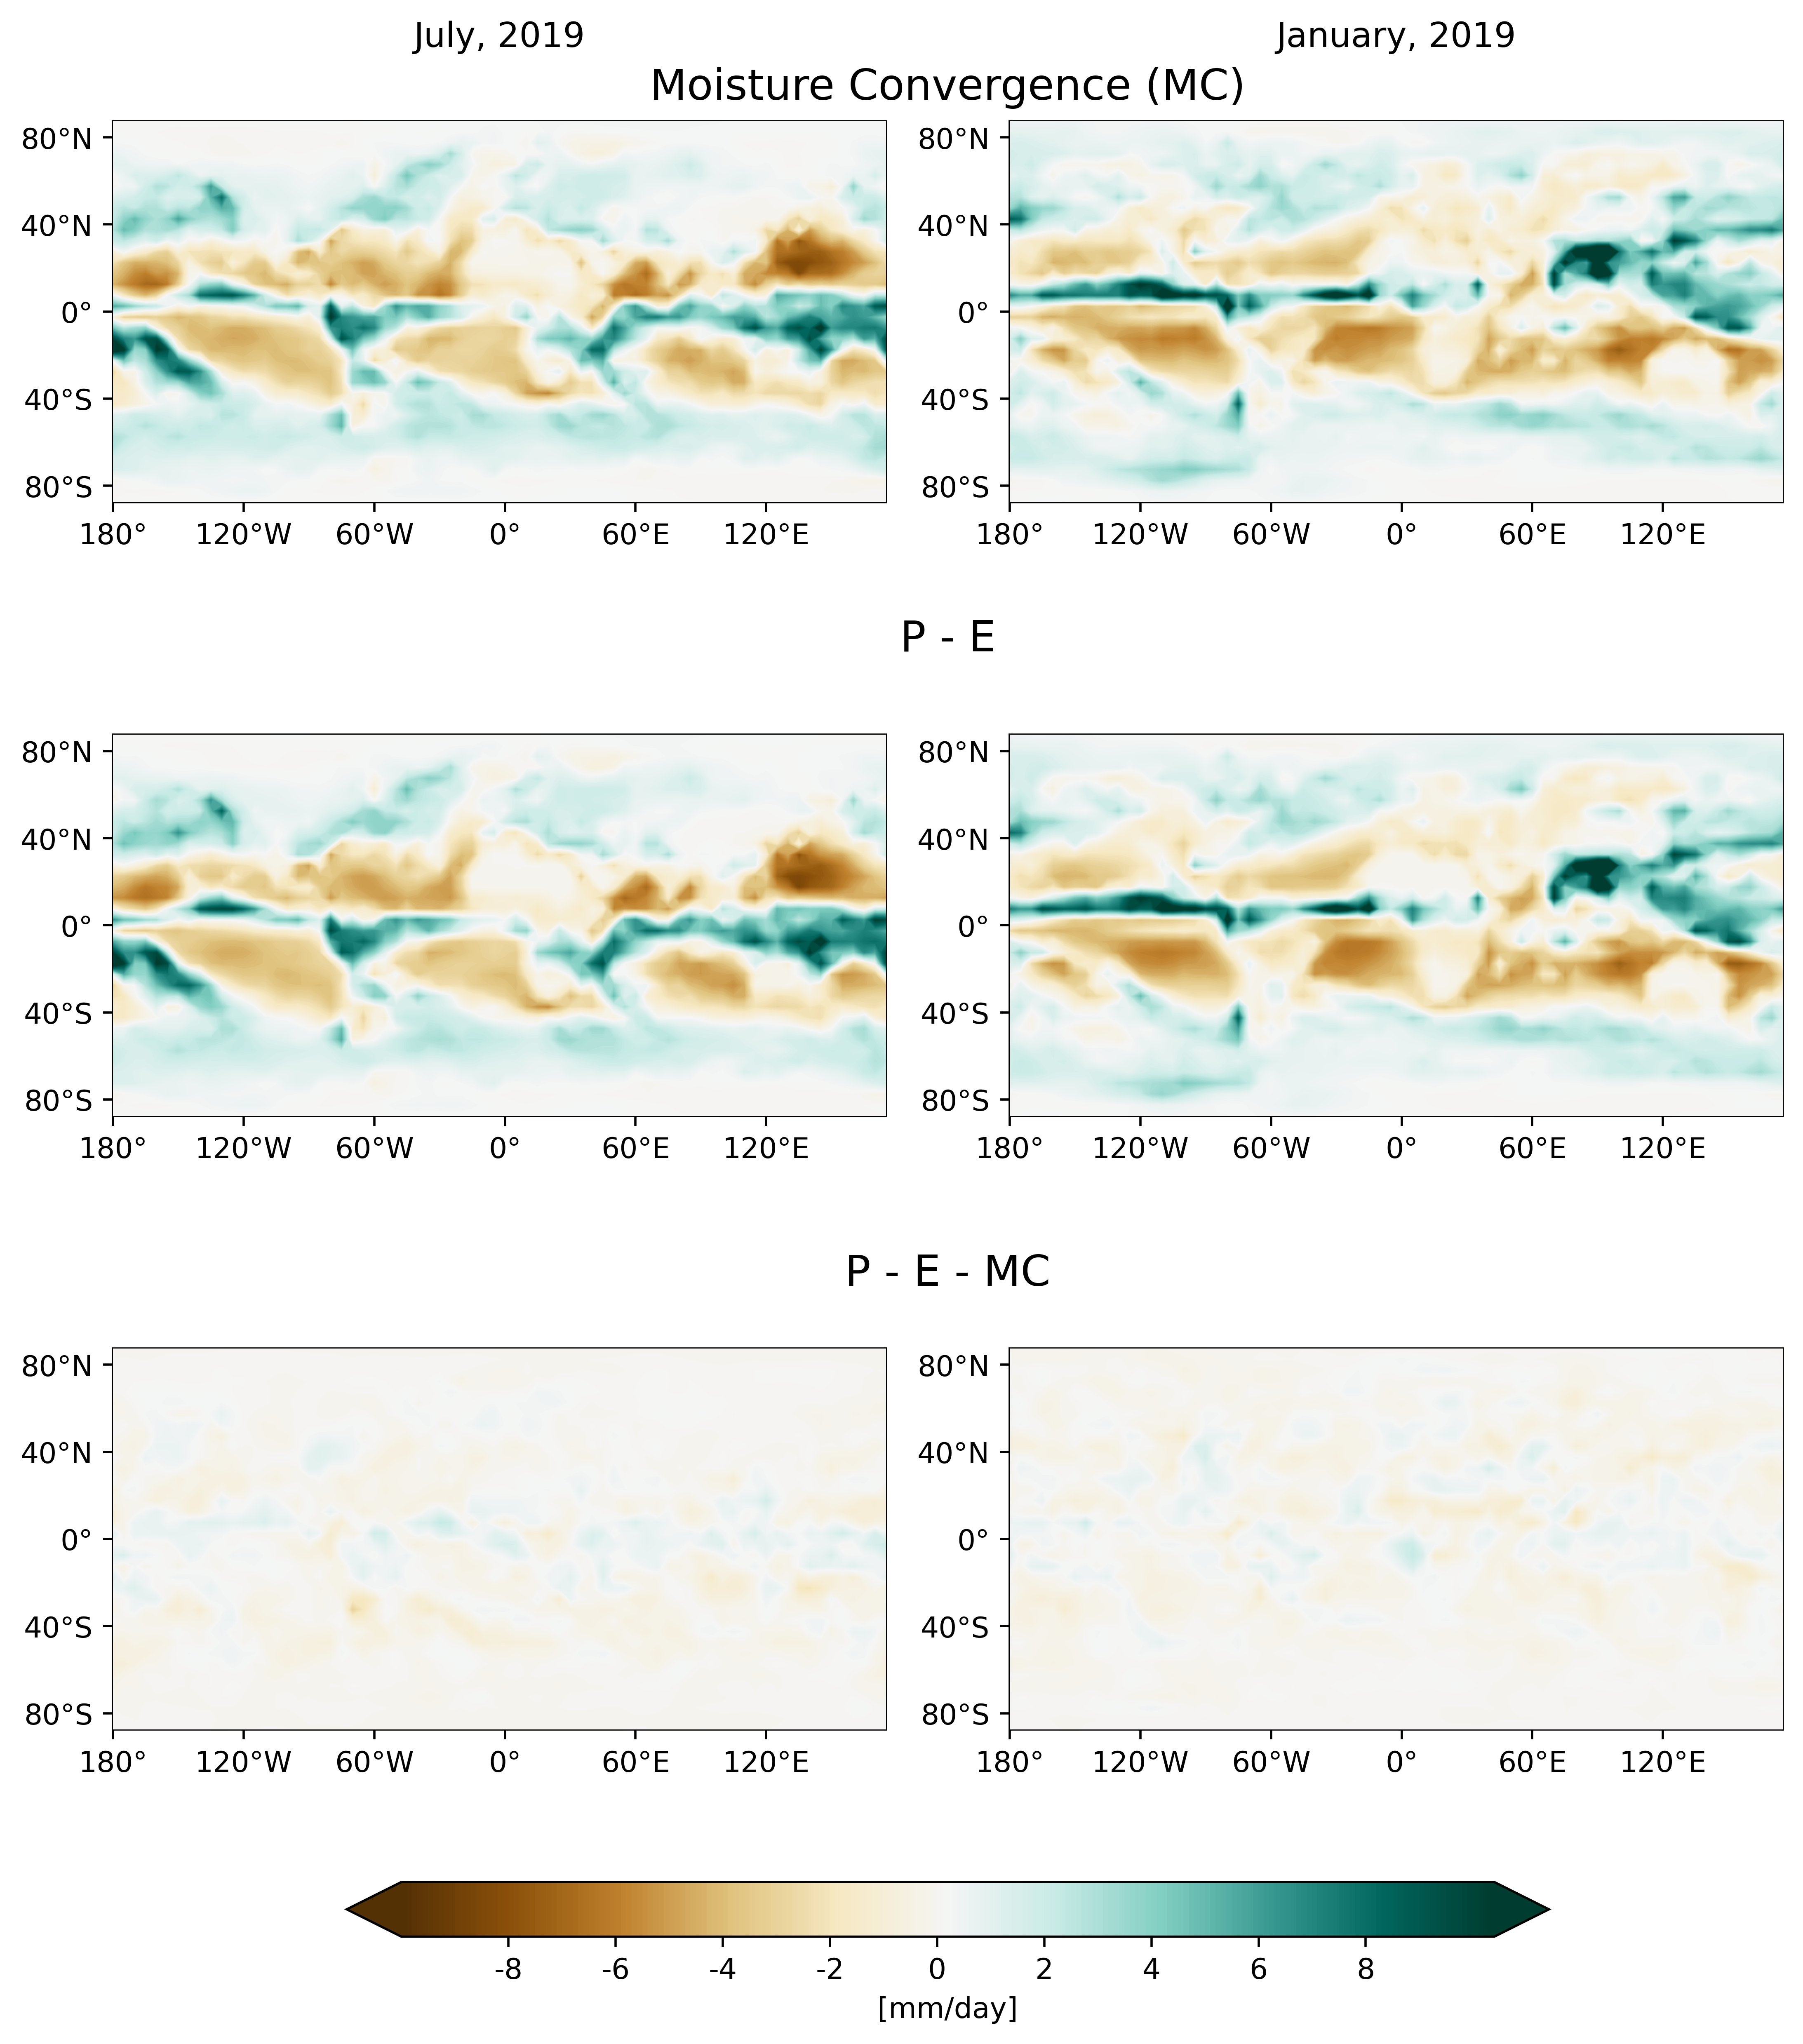

In [56]:
# plotting: Compare the Moisture convergence with P (Precip) minus E (Evaporation) in ERA-5..

# plot settings:
parameters = {'axes.labelsize': 18, 'legend.fontsize': 14,
         'axes.titlesize': 22,  'xtick.labelsize': 16,  'ytick.labelsize': 16}
plt.rcParams.update(parameters)

# X, Y coordinates
X, Y = np.meshgrid(x_range, s_range)

proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(9., 14.), dpi = 500)
fig.subplots_adjust(wspace = 0.16, hspace = 0.30, left = 0.05, right = 0.95)

ax1 = plt.subplot(321, projection = proj)
ax2 = plt.subplot(322, projection = proj)
ax3 = plt.subplot(323, projection = proj)
ax4 = plt.subplot(324, projection = proj)
ax5 = plt.subplot(325, projection = proj)
ax6 = plt.subplot(326, projection = proj)

# country border, coastline, Rivers, Lakes ...
ax1.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
ax2.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
ax3.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
ax4.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
ax5.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
ax6.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)

# label Latitude/lonitude line
xticks = np.arange(-180.,180., 60.)
yticks = np.arange(-80.,90., 40.)
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
# ax1.xaxis.set_minor_locator(mticker.MultipleLocator(5))  #..minor ticks

ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.xaxis.set_major_formatter(LongitudeFormatter())
ax2.yaxis.set_major_formatter(LatitudeFormatter())
# ax2.xaxis.set_minor_locator(mticker.MultipleLocator(5))  #..minor ticks

ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.xaxis.set_major_formatter(LongitudeFormatter())
ax3.yaxis.set_major_formatter(LatitudeFormatter())
# ax3.xaxis.set_minor_locator(mticker.MultipleLocator(5))  #..minor ticks

ax4.set_xticks(xticks)
ax4.set_yticks(yticks)
ax4.xaxis.set_major_formatter(LongitudeFormatter())
ax4.yaxis.set_major_formatter(LatitudeFormatter())
# ax4.xaxis.set_minor_locator(mticker.MultipleLocator(5))  #..minor ticks

ax5.set_xticks(xticks)
ax5.set_yticks(yticks)
ax5.xaxis.set_major_formatter(LongitudeFormatter())
ax5.yaxis.set_major_formatter(LatitudeFormatter())
# ax5.xaxis.set_minor_locator(mticker.MultipleLocator(5))  #..minor ticks

ax6.set_xticks(xticks)
ax6.set_yticks(yticks)
ax6.xaxis.set_major_formatter(LongitudeFormatter())
ax6.yaxis.set_major_formatter(LatitudeFormatter())
# ax6.xaxis.set_minor_locator(mticker.MultipleLocator(5))  #..minor ticks

# Plot setting:
clevel = np.arange(-10., 10.5, 0.1)
clevel_minus = np.arange(-2.5, 2.6, 0.02)

# July:

# MC, unit in mm day^-1
contourf1 = ax1.contourf(X, Y, (-1. * MC_Jan_binned), levels= clevel, cmap='BrBG', zorder = 3, extend = 'both')
# P - E. unit in mm day^-1
contourf3 = ax3.contourf(X, Y, (P_Jan_binned + E_Jan_binned), levels= clevel, cmap='BrBG', zorder = 3, extend = 'both')
# (MC - (P-E)), unit in mm day^-1
contourf5 = ax5.contourf(X, Y, ((P_Jan_binned + E_Jan_binned) - (-1. * MC_Jan_binned)), levels= clevel, cmap='BrBG', zorder = 3, extend = 'both')

# January:
# MC, unit in mm day^-1
contourf2 = ax2.contourf(X, Y, (-1. * MC_July_binned), levels= clevel, cmap='BrBG', zorder = 3, extend = 'both')
# P - E. unit in mm day^-1
contourf4 = ax4.contourf(X, Y, (P_July_binned + E_July_binned), levels= clevel, cmap='BrBG', zorder = 3, extend = 'both')
# (MC - (P-E)), unit in mm day^-1
contourf6 = ax6.contourf(X, Y, ((P_July_binned + E_July_binned) - (-1. * MC_July_binned)), levels= clevel, cmap='BrBG', zorder = 3, extend = 'both')

# color bar:
cb1 = fig.colorbar(contourf1, ax = [ax1, ax2, ax3, ax4, ax5, ax6], orientation='horizontal', label='[mm/day]', shrink=0.72, pad=0.07) 
cb1.set_ticks(np.array([-8.,-6.,-4.,-2., 0., 2., 4., 6., 8.]))
cb1.set_ticklabels([-8,-6,-4,-2, 0, 2, 4, 6, 8])

# cb2 = fig.colorbar(contourf5, ax = [ax5, ax6], orientation='horizontal', label='[mm/day]', shrink=0.72, pad=0.17)
# cb2.set_ticks(np.array([-2.,-1.5,-1.,-0.5, 0., 0.5, 1., 1.5, 2.]))
# cb2.set_ticklabels([-2,-1.5,-1,-0.5, 0, 0.5, 1, 1.5, 2])


# Set shared title for row plots:

extent = ([[ax1.get_window_extent().x0, ax1.get_window_extent().width],
          [ax2.get_window_extent().x0, ax2.get_window_extent().width]])
# [[ax0_x0,ax0_width], [ax1_x0, ax1_width]]

# from the axes bounding boxes calculate the optimal position of the column spanning title
inv = fig.transFigure.inverted()

width = extent[0][0]+(extent[1][0]+extent[1][1]-extent[0][0])/2.
pos_center = inv.transform( (width, 1) )

# add gtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(pos_center[0], 0.860, "Moisture Convergence (MC)", va="center", ha="center", size = 15)
plt.figtext(pos_center[0], 0.669, "P - E", va="center", ha="center", size = 15)
plt.figtext(pos_center[0], 0.449, "P - E - MC", va="center", ha="center", size = 15)

# title:
ax1.set_title('July, 2019', loc='center', pad = 26.)
ax2.set_title('January, 2019', loc='center', pad = 26.)

plt.savefig(path_plot + "Fig_S1.jpg", bbox_inches = 'tight')